In [1]:
import numpy as np
import glob
import cv2
import pickle
import matplotlib.pyplot as plt

**ROI List** (If you want to change to other data, please restart and clear output)

| **Data Name** | **ROI** |
|---|---|
|00beeb02-50440dcd|(0.4,0.45),(0.52,0.45),(0.1,0.7),(0.9,0.7)|
|01c5fd90-949d2d90|(0.27,0.48),(0.5,0.48),(0.15,0.73),(0.7,0.71)|
|b1f6c103-5ce1f3c6|(0.32,0.48),(0.46,0.48),(0,0.83),(0.62,0.83)|
|cadb239d-0776327a|(0.42,0.48),(0.61,0.48),(0,0.83),(0.93,0.83)|
|cb86b1d9-7735472c|(0.7,0.62),(0.78,0.62),(0.31,0.83),(0.88,0.83)|
|cb55a21f-dab8ad35|(0.46,0.65),(0.63,0.65),(0.14,0.83),(0.8,0.83)|
|b3a1e72b-f9a8ed50|(0.46,0.45),(0.58,0.45),(0.33,0.65),(0.68,0.65)|
|b3c939e3-370d8f4a|(0.36,0.56),(0.63,0.56),(0.15,0.9),(0.97,0.9)|
|b4e927af-828f4a9b|(0.4,0.53),(0.61,0.53),(0.28,0.8),(0.78,0.8)|
|0b1b5202-1d080218|(0.32,0.52),(0.46,0.52),(0.25,0.76),(0.62,0.76)|


**Read Image**

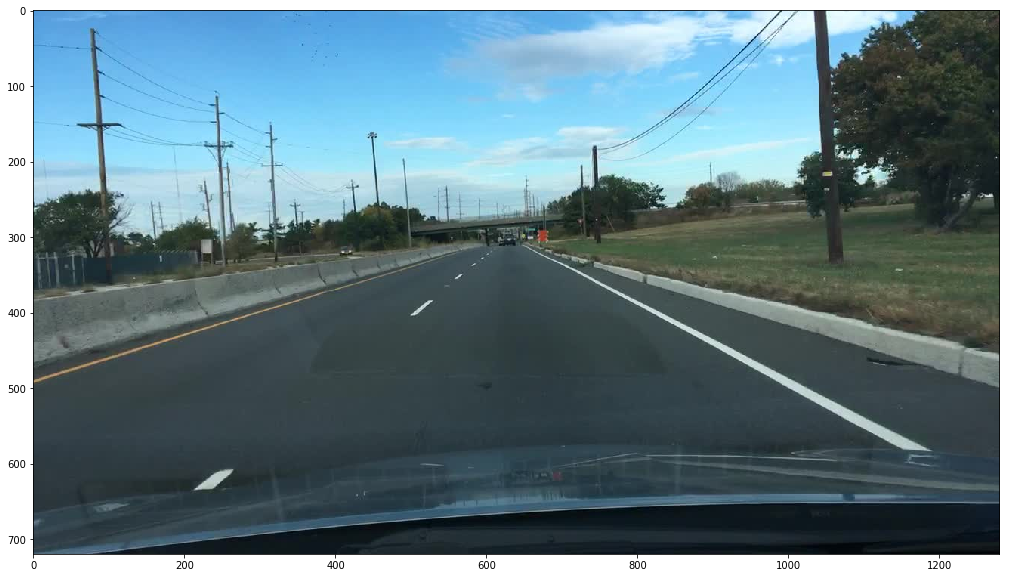

In [2]:
image = cv2.imread('./used_data/00beeb02-50440dcd.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(image)



**Functions**

In [3]:
def lane_candidate(image, sat_thresh=(100, 255), sobel_thresh=(15, 255)):
    image = np.copy(image)
    
    # Convery RGB to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float) 
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Derivative on horizontal direction using Sobel in lightness channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) # Normalized magnitude of gradient
    
    # Threshold x gradient
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold in saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sat_thresh[0]) & (s_channel <= sat_thresh[1])] = 1 
     
    
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1 # yellow or white lane
    
    # Do additional mask to eliminate obstacles
    
    return combined_binary

def perspective_warp(image, 
                     dest_size=(1280,720), # Image size
                     source=np.float32([(0.4,0.45),(0.52,0.45),(0.1,0.7),(0.9,0.7)]), # Specify the ROI, LT-RT-LB-RB 
                     destination=np.float32([(0,0), (1, 0), (0,1), (1,1)])): # Mapping to new domain
    
    image_size = np.float32([(image.shape[1],image.shape[0])])
    
    source = source* image_size
    destination = destination * np.float32(dest_size)
    
    # Calculate Perspective transform
    Per_matrix = cv2.getPerspectiveTransform(source, destination)
    
    # Warp the image
    warped_image = cv2.warpPerspective(image, Per_matrix, dest_size)
    return warped_image

def inv_perspective_warp(image, 
                     dest_size=(1280,720),
                     source=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
                     destination=np.float32([(0.4,0.45),(0.52,0.45),(0.1,0.7),(0.9,0.7)])): # Specify the ROI, LT-RT-LB-RB 
    image_size = np.float32([(image.shape[1],image.shape[0])])
    source = source* image_size
    destination = destination * np.float32(dest_size)
    # Calculate Inverse Perspective transform
    Per_matrix = cv2.getPerspectiveTransform(source, destination)
    # Warp the image
    warped_image = cv2.warpPerspective(image, Per_matrix, dest_size)
    return warped_image


In [4]:
def get_hist(image):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0) 
    return histogram


In [5]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(image, num_windows=9, win_margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c, right_a, right_b, right_c 
    draw_left_fit_= np.empty(3)
    draw_right_fit_ = np.empty(3)
    out_image = np.dstack((image, image, image))*255

    histogram = get_hist(image)
    # Find starting points from histogram
    midpoint = int(histogram.shape[0]/2)
    leftxpos_base = np.argmax(histogram[:midpoint])
    rightxpos_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(image.shape[0]/num_windows) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzero_xpos = np.array(nonzero[1])
    nonzero_ypos = np.array(nonzero[0])
    
    # Current positions to be updated for each window
    leftxpos_current = leftxpos_base
    rightxpos_current = rightxpos_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(num_windows):
        win_left_low = leftxpos_current - win_margin 
        win_left_high = leftxpos_current + win_margin
        win_right_low = rightxpos_current - win_margin
        win_right_high = rightxpos_current + win_margin
        win_height_low = image.shape[0] - (window+1)*window_height
        win_height_high = image.shape[0] - window*window_height
 
        # Draw the windows
        if draw_windows == True:
            cv2.rectangle(out_image,(win_left_low,win_height_low),(win_left_high,win_height_high),(100,255,255), 3) 
            cv2.rectangle(out_image,(win_right_low,win_height_low),(win_right_high,win_height_high),(100,255,255), 3) 
            
        # Identify the nonzero pixels' locations within the window
        left_inds = ((nonzero_ypos >= win_height_low) & (nonzero_ypos < win_height_high) & 
        (nonzero_xpos >= win_left_low) &  (nonzero_xpos < win_left_high)).nonzero()[0]
        right_inds = ((nonzero_ypos >= win_height_low) & (nonzero_ypos < win_height_high) & 
        (nonzero_xpos >= win_right_low) &  (nonzero_xpos < win_right_high)).nonzero()[0]

        # Pixels of interest
        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)
        
        # Base location of next window
        if len(left_inds) > minpix:
            leftxpos_current = np.int(np.mean(nonzero_xpos[left_inds]))
        if len(right_inds) > minpix:        
            rightxpos_current = np.int(np.mean(nonzero_xpos[right_inds]))
        
    # Pixels of interest
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right lane pixel positions
    left_xpos = nonzero_xpos[left_lane_inds]
    left_ypos = nonzero_ypos[left_lane_inds] 
    right_xpos = nonzero_xpos[right_lane_inds]
    right_ypos = nonzero_ypos[right_lane_inds] 

    # Fit second order polynomial
    left_fit = np.polyfit(left_ypos, left_xpos, 2)
    right_fit = np.polyfit(right_ypos, right_xpos, 2)
    
    # Collect coefficients of left lane
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    # Collect coefficients of right lane
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    # Mean value of recent 10 coefficients
    draw_left_fit_[0] = np.mean(left_a[-10:])
    draw_left_fit_[1] = np.mean(left_b[-10:])
    draw_left_fit_[2] = np.mean(left_c[-10:])
    
    # Mean value of recent 10 coefficients
    draw_right_fit_[0] = np.mean(right_a[-10:])
    draw_right_fit_[1] = np.mean(right_b[-10:])
    draw_right_fit_[2] = np.mean(right_c[-10:])
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    plot_left_fitx = draw_left_fit_[0]*ploty**2 + draw_left_fit_[1]*ploty + draw_left_fit_[2]
    plot_right_fitx = draw_right_fit_[0]*ploty**2 + draw_right_fit_[1]*ploty + draw_right_fit_[2]

    
    return (plot_left_fitx, plot_right_fitx)


def draw_lanes(image, plot_left_fit, plot_right_fit):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    color_image = np.zeros_like(image)
    
    left_fit = np.array([np.transpose(np.vstack([plot_left_fit, ploty]))])
    right_fit = np.array([np.flipud(np.transpose(np.vstack([plot_right_fit, ploty])))]) 
    
    # Use cv2.line for left lane in 9th data, rainy weather
    #cv2.line(color_image, tuple(np.int_(left_fit[0,0,:])),  tuple(np.int_(left_fit[0,-1,:])), (255,0,0), 30)  
    cv2.polylines(color_image, np.int_(left_fit), False, (255,0,0),30) 
    cv2.polylines(color_image, np.int_(right_fit),False, (255,0,0),30) 
        
    inv_perspective = inv_perspective_warp(color_image)
    inv_perspective = cv2.addWeighted(image, 1, inv_perspective, 0.7, 0)
    return inv_perspective

Text(0.5, 1.0, 'Wrapped Image')

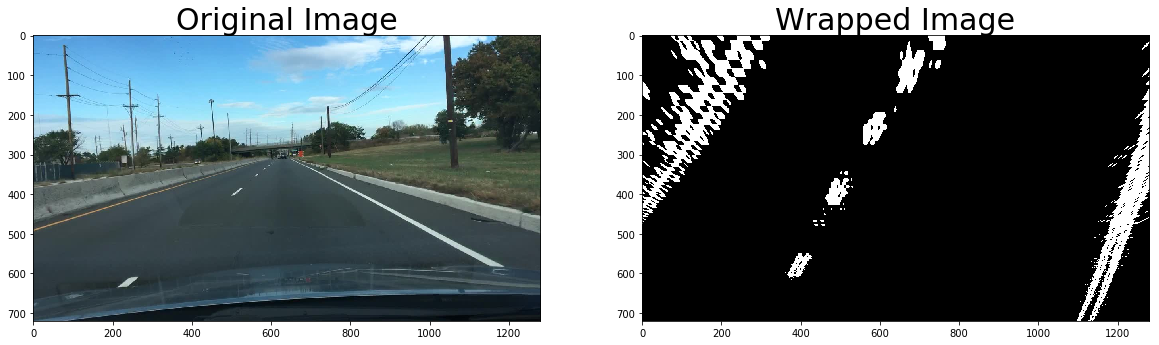

In [6]:
candidate = lane_candidate(image)
candidate = perspective_warp(candidate)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(candidate, cmap='gray')
ax2.set_title('Wrapped Image', fontsize=30)

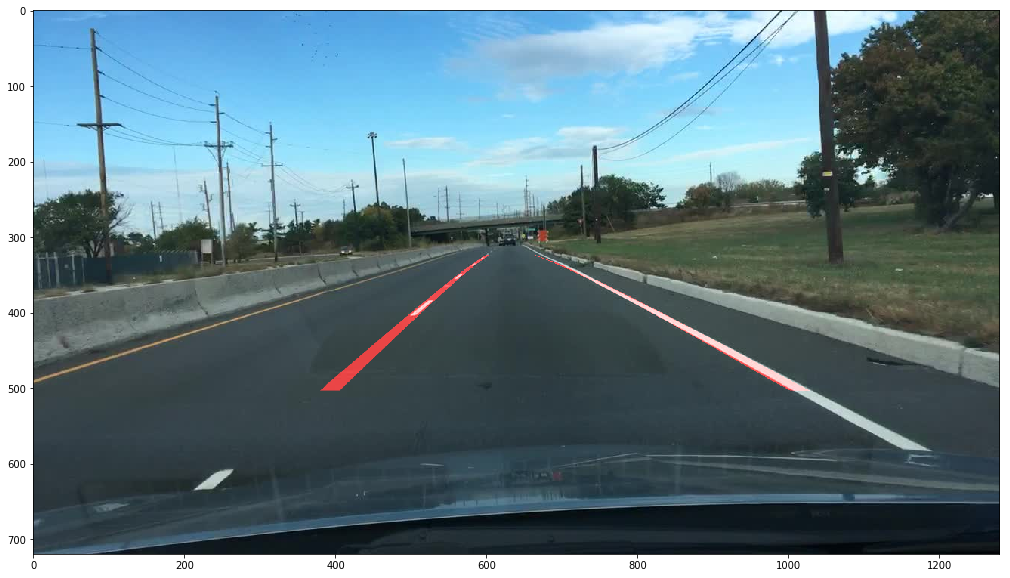

In [7]:
curve_info = sliding_window(candidate)
plt.figure(figsize=(20,10))
final_image = draw_lanes(image, curve_info[0], curve_info[1])
plt.imshow(final_image)